# Authenticating Bank Notes

In [1]:
# importing the usual suspects

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## The data

In [2]:
# reading in the data, displaying first 5 rows

bank_notes=pd.read_csv('data-banknote-authentication.csv')

bank_notes.head()

,Variance_Wavelet,Skewness_Wavelet,Curtosis_Wavelet,Image_Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
bank_notes.shape

(1372, 5)

The data has 5 features and 1372 observations.

In [4]:
bank_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Variance_Wavelet  1372 non-null   float64
 1   Skewness_Wavelet  1372 non-null   float64
 2   Curtosis_Wavelet  1372 non-null   float64
 3   Image_Entropy     1372 non-null   float64
 4   Class             1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


The data types are all right.

In [5]:
# checking for null values

bank_notes.isnull().sum()

Variance_Wavelet    0
Skewness_Wavelet    0
Curtosis_Wavelet    0
Image_Entropy       0
Class               0
dtype: int64

In [6]:
# a statistical summary of our data

bank_notes.describe().T

,count,mean,std,min,25%,50%,75%,max
Variance_Wavelet,1372.0,0.433735,2.842763,-7.0421,-1.773000,0.49618,2.821475,6.8248
Skewness_Wavelet,1372.0,1.922353,5.869047,-13.7731,-1.708200,2.31965,6.814625,12.9516
Curtosis_Wavelet,1372.0,1.397627,4.310030,-5.2861,-1.574975,0.61663,3.179250,17.9274
Image_Entropy,1372.0,-1.191657,2.101013,-8.5482,-2.413450,-0.58665,0.394810,2.4495
Class,1372.0,0.444606,0.497103,0.0000,0.000000,0.00000,1.000000,1.0000


In [7]:
# checking the class balance

bank_notes['Class'].value_counts(normalize=True)*100

0    55.539359
1    44.460641
Name: Class, dtype: float64

Approximately 56% of the notes are authentic with the remaining 44% being fake.

<AxesSubplot:xlabel='Class', ylabel='count'>

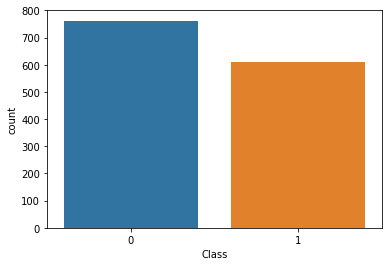

In [8]:
# visualizing the balance

sns.countplot(x='Class', data=bank_notes)

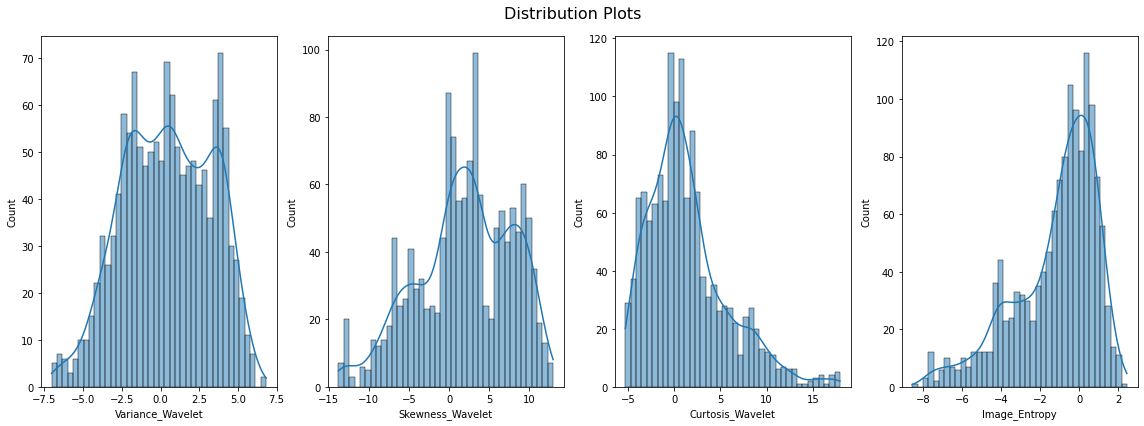

In [9]:
# visulaizing the distribution of each feature

fig, axes = plt.subplots(1,4, figsize=(16,6))

for index, column in enumerate(bank_notes.columns[:4]):
    sns.histplot(bank_notes[column], kde=True, bins=40, ax=axes[index])

fig.suptitle('Distribution Plots', fontsize=16)    
    
plt.tight_layout()

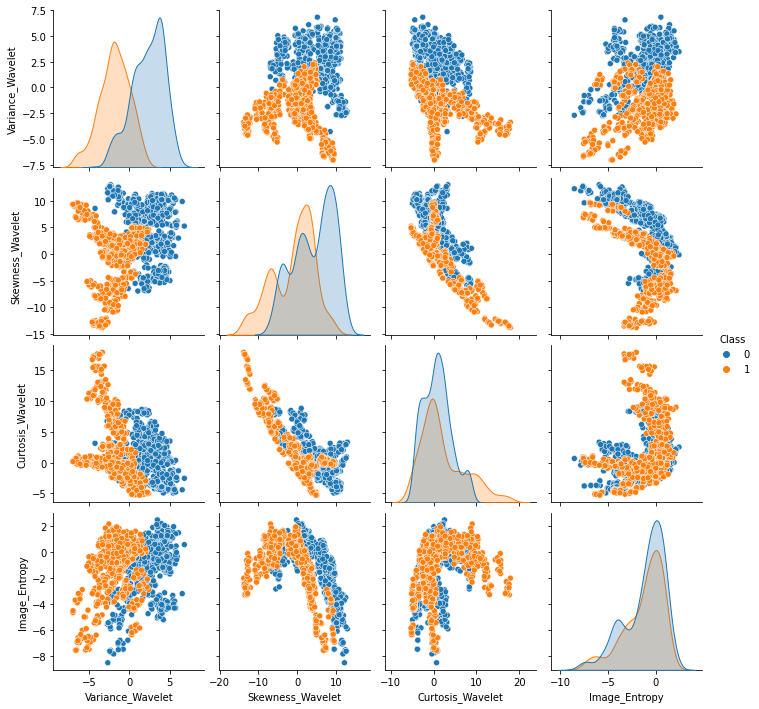

In [10]:
sns.pairplot(bank_notes, hue='Class')

`image_Entropy` and `Curtosis_Wavelet` are quite similar as the points overlap. 

There is clear separation of the distributions of the labels. Models should therefore perform well.

In [11]:
# how correlated are our features to the class label?

bank_notes.corr()['Class'][:-1].sort_values(ascending=False)

Curtosis_Wavelet    0.155883
Image_Entropy      -0.023424
Skewness_Wavelet   -0.444688
Variance_Wavelet   -0.724843
Name: Class, dtype: float64

`Variance_Wavelet` has the most signal. It may turn out to be our most important feature. We'll find out for sure later.

<AxesSubplot:>

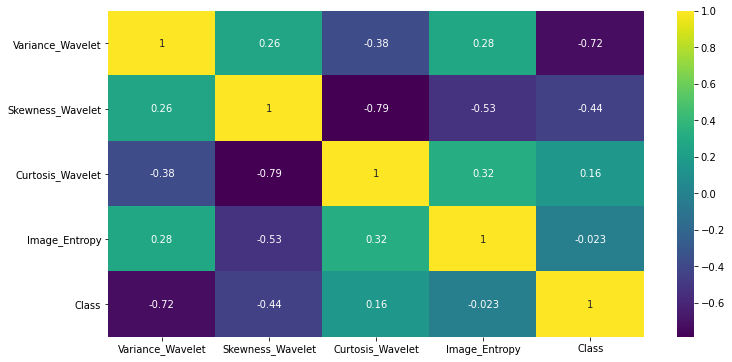

In [12]:
# a heatmap to show the correlations

plt.figure(figsize=(12,6))
sns.heatmap(bank_notes.corr(), annot=True, cmap='viridis')

In [13]:
# defining the features and the label

X=bank_notes.drop('Class', axis=1)
y=bank_notes['Class']

## Train/validation/test split

The idea is to fit different models to the training data and evaluate each one on the validation set. Then the best performing model will be picked and scored on the test set. This will be a good indicator of its future performance. 

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# 70% of our data will be used for training the models

X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.3, random_state=101)

In [16]:
# the evaluation and test sets split the remaining 30% down the middle (50-50 split), leaving each set with 15% of the overall data

X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=101)

Feature scaling is not necessary since we will be using tree-based methods. Split is based off a single feature which means there is no need to standardize/normalize that particular feature in terms of other features.

## Modelling

The plan is to use default `decision trees`, `random forests` and `boosted trees` to predict whether a note is authentic or counterfeit.

Results will be evaluated after which hyperparameter tuning will be done (if necessary).

The model that performs best on the validation set will be chosen as the 'champion' and scored on the test set.

### Decision tree

In [17]:
# importing the decision tree classifier

from sklearn.tree import DecisionTreeClassifier

In [18]:
# an instance of the classifier with default hyperparameters
# a random state ensures the results are reproducible
# it is an arbitrary value; could therefore be anything

base_dtc=DecisionTreeClassifier(random_state=101)

In [19]:
# fitting

base_dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=101)

In [20]:
# importing the evaluation metrics

from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [21]:
# predicting off the validation set

base_dtc_preds = base_dtc.predict(X_val)

In [22]:
base_dtc_accuracy=np.round(accuracy_score(y_val, base_dtc_preds),4)
print('base_dtc_accuracy:', np.round(base_dtc_accuracy,4))

base_dtc_precision=np.round(precision_score(y_val, base_dtc_preds),4)
print('base_dtc_precision:', base_dtc_precision)

base_dtc_recall=np.round(recall_score(y_val, base_dtc_preds),4)
print('base_dtc_recall:', base_dtc_recall)

base_dtc_f1=np.round(f1_score(y_val, base_dtc_preds),4)
print('base_dtc_f1:', base_dtc_f1)

base_dtc_accuracy: 0.9854
base_dtc_precision: 0.9615
base_dtc_recall: 1.0
base_dtc_f1: 0.9804


In [23]:
print(classification_report(y_val, base_dtc_preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       131
           1       0.96      1.00      0.98        75

    accuracy                           0.99       206
   macro avg       0.98      0.99      0.98       206
weighted avg       0.99      0.99      0.99       206



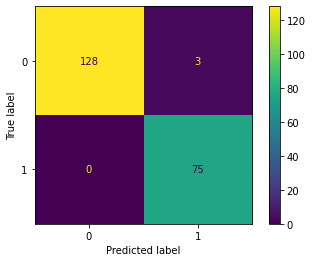

In [24]:
plot_confusion_matrix(base_dtc, X_val, y_val)

The model caught all the fake bills but misclassified 3 authentic ones.

In [25]:
dtc_feat_imp=pd.DataFrame(index=X.columns, columns=['Importance'], data=base_dtc.feature_importances_)

In [26]:
dtc_feat_imp

,Importance
Variance_Wavelet,0.636716
Skewness_Wavelet,0.218641
Curtosis_Wavelet,0.132978
Image_Entropy,0.011665


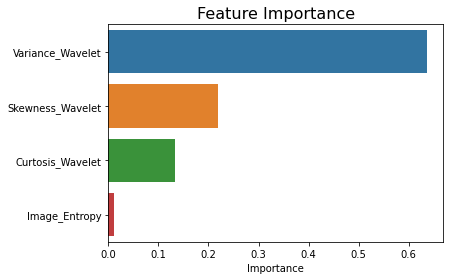

In [27]:
sns.barplot(x='Importance', y=dtc_feat_imp.index, data=dtc_feat_imp)
plt.title('Feature Importance', fontsize=16);

`Variance_Wavelet` is by far the most important feature.

In [28]:
from sklearn.tree import plot_tree

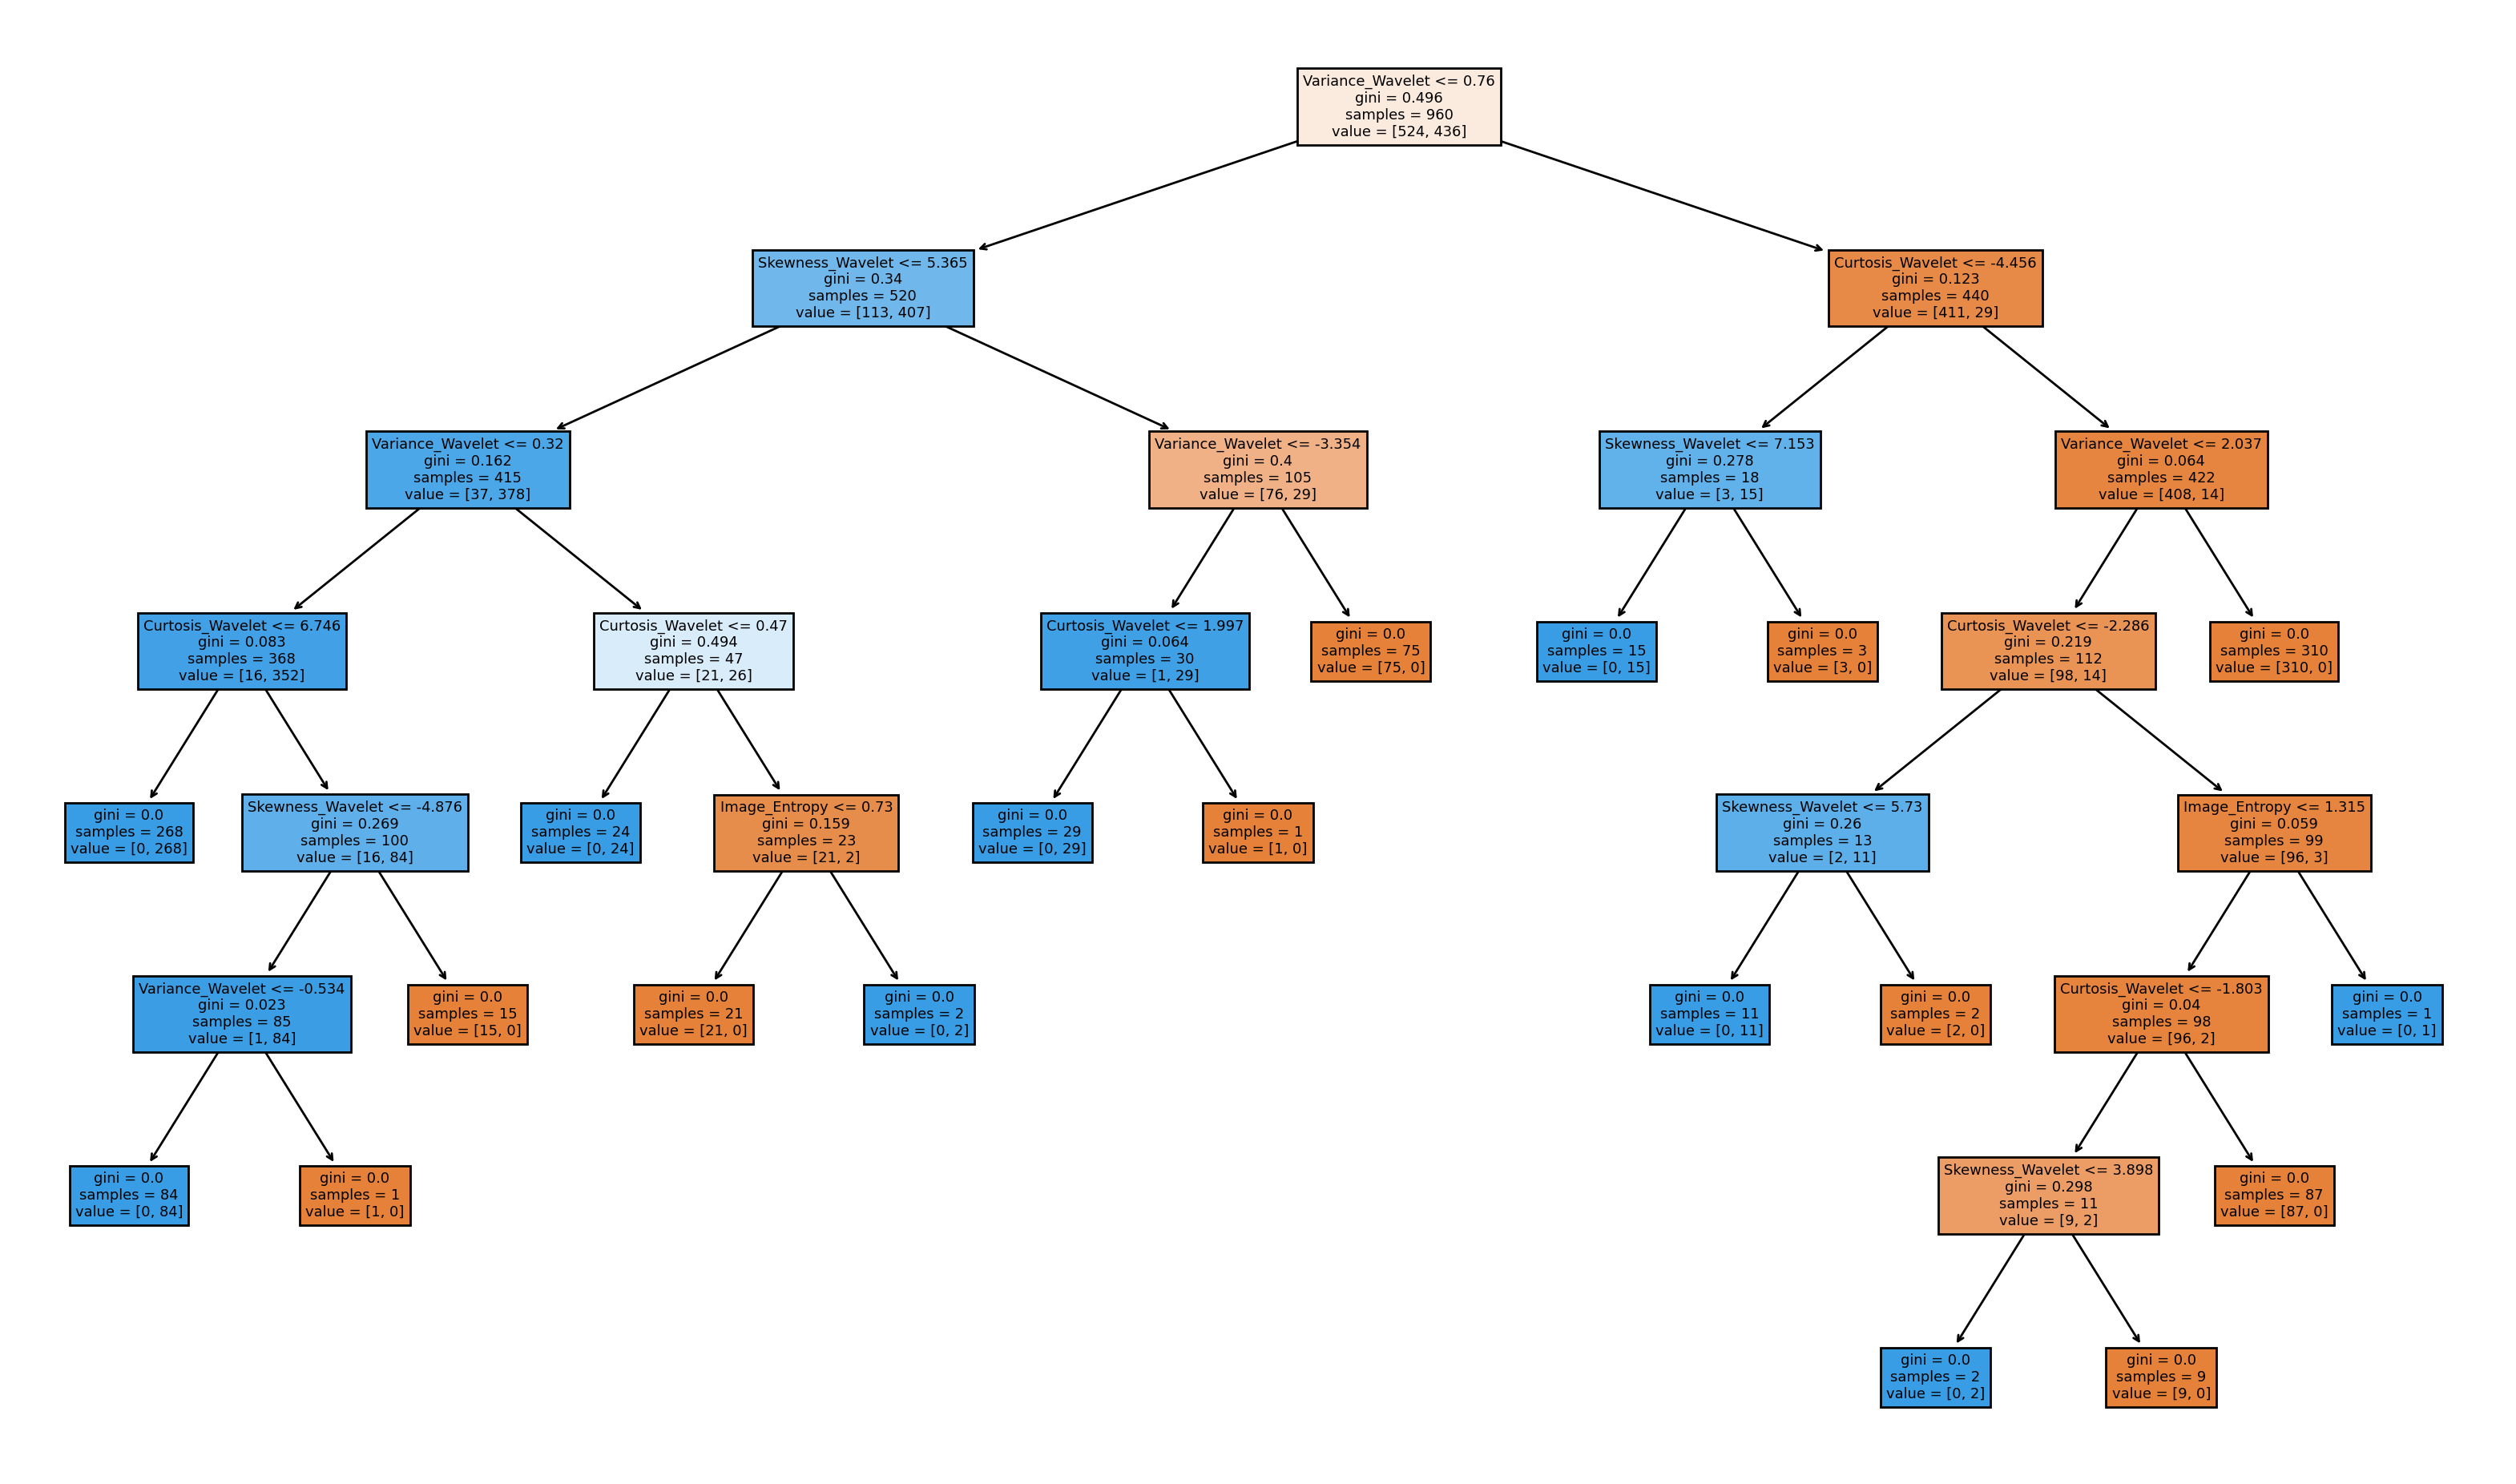

In [29]:
# plotting the decision tree

plt.figure(figsize=(20,12), dpi=200)
plot_tree(base_dtc, feature_names=X.columns, filled=True);

### Random forest

In [30]:
# import RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

In [31]:
# instantiating the classifier

base_rfc=RandomForestClassifier(random_state=101)

In [32]:
# fit the training data to the model instance

base_rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=101)

In [33]:
# predict off the validation set

base_rfc_preds=base_rfc.predict(X_val)

In [34]:
# evaluation

base_rfc_accuracy=np.round(accuracy_score(y_val, base_rfc_preds),4)
print('base_rfc_accuracy:', base_rfc_accuracy)

base_rfc_precision=np.round(precision_score(y_val, base_rfc_preds),4)
print('base_drfc_precision:', base_rfc_precision)

base_rfc_recall=np.round(recall_score(y_val, base_rfc_preds),4)
print('base_rfc_recall:', base_rfc_recall)

base_rfc_f1=np.round(f1_score(y_val, base_rfc_preds),4)
print('base_rfc_f1:', base_rfc_f1)

base_rfc_accuracy: 0.9854
base_drfc_precision: 0.9615
base_rfc_recall: 1.0
base_rfc_f1: 0.9804


In [35]:
print(classification_report(y_val, base_rfc_preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       131
           1       0.96      1.00      0.98        75

    accuracy                           0.99       206
   macro avg       0.98      0.99      0.98       206
weighted avg       0.99      0.99      0.99       206



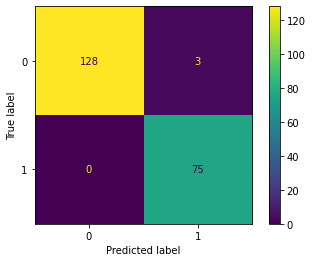

In [36]:
plot_confusion_matrix(base_rfc, X_val, y_val)

Good performance yet again. All the counterfeit bills were classified correctly and only 3 authentic ones were misclassified. 

In [37]:
base_rfc.feature_importances_

array([0.56999929, 0.22587541, 0.15326141, 0.05086389])

In [38]:
rfc_feat_imp=pd.DataFrame(index=X.columns, columns=['Importance'], data=base_rfc.feature_importances_)

In [39]:
rfc_feat_imp

,Importance
Variance_Wavelet,0.569999
Skewness_Wavelet,0.225875
Curtosis_Wavelet,0.153261
Image_Entropy,0.050864


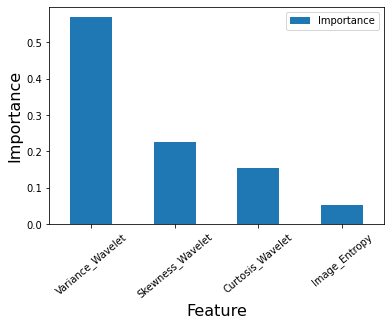

In [40]:
rfc_feat_imp.plot(kind='bar')
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Importance', fontsize=16)
plt.xticks(rotation=40);

`Variance_Wavelet` is far and away the most important feature.

### XGBoost

In [41]:
# mport XGBoostClassifer

from xgboost import XGBClassifier

In [42]:
# instance of the classifier

base_xgbc=XGBClassifier(objective='binary:logistic', random_state=101)

The objective is `binary:logistic` because our model will be performing a binary classification task that outputs a logistic probability.

In [43]:
# fit the model

base_xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=101,
              reg_alpha=0, reg_lambda=1, ...)

In [44]:
# predictions

base_xgbc_preds=base_xgbc.predict(X_val)

In [45]:
# evaluation

base_xgbc_accuracy=np.round(accuracy_score(y_val, base_xgbc_preds),4)
print('base_xgbc_accuracy:', base_xgbc_accuracy)

base_xgbc_precision=np.round(precision_score(y_val, base_xgbc_preds),4)
print('base_xgbc_precision:', base_xgbc_precision)

base_xgbc_recall=np.round(recall_score(y_val, base_xgbc_preds),4)
print('base_xgbc_recall:', base_xgbc_recall)

base_xgbc_f1=np.round(f1_score(y_val, base_xgbc_preds),4)
print('base_xgbc_f1:', base_xgbc_f1)

base_xgbc_accuracy: 0.9951
base_xgbc_precision: 0.9868
base_xgbc_recall: 1.0
base_xgbc_f1: 0.9934


In [46]:
print(classification_report(y_val, base_xgbc_preds))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       131
           1       0.99      1.00      0.99        75

    accuracy                           1.00       206
   macro avg       0.99      1.00      0.99       206
weighted avg       1.00      1.00      1.00       206



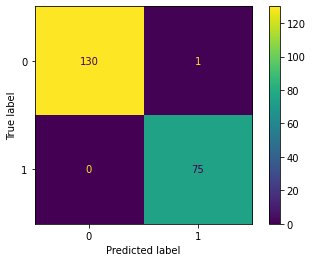

In [47]:
plot_confusion_matrix(base_xgbc, X_val, y_val)

XGBoost catches all the counterfeit bills and mislabels only a single genuine one.

In [48]:
from xgboost import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

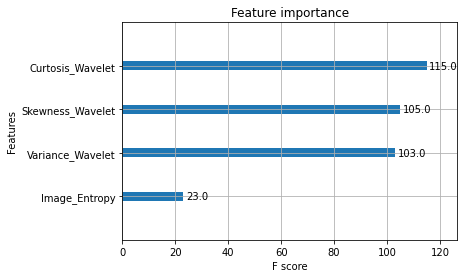

In [49]:
plot_importance(base_xgbc)

In [50]:
xgbc_feat_imp=pd.DataFrame(index=X.columns, columns=['Importance'], data=base_xgbc.feature_importances_)

In [51]:
xgbc_feat_imp

,Importance
Variance_Wavelet,0.615333
Skewness_Wavelet,0.209661
Curtosis_Wavelet,0.125138
Image_Entropy,0.049868


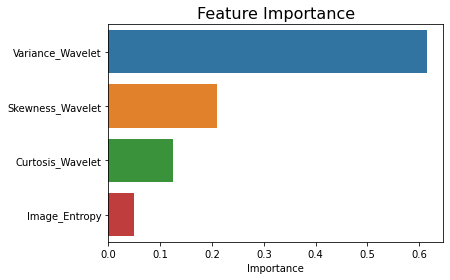

In [52]:
sns.barplot(x='Importance', y=xgbc_feat_imp.index, data=xgbc_feat_imp)
plt.title('Feature Importance', fontsize=16);

## Results

In [53]:
# create a dictionary of the results; cast into a dataframe

data_dict={'Decision Tree':[base_dtc_accuracy, base_dtc_precision, base_dtc_recall, base_dtc_f1],
          'Random Forest':[base_rfc_accuracy, base_rfc_precision, base_rfc_recall, base_rfc_f1],
          'XGBoost':[base_xgbc_accuracy, base_xgbc_precision, base_xgbc_recall, base_xgbc_f1]}

results=pd.DataFrame(data=data_dict.values(), index=data_dict.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1'])
print(results)

               Accuracy  Precision  Recall      F1
Decision Tree    0.9854     0.9615     1.0  0.9804
Random Forest    0.9854     0.9615     1.0  0.9804
XGBoost          0.9951     0.9868     1.0  0.9934


All the models perform exceptionally well with XGBoost rising to the top.

Tuning the hyperparameters for any of the models would be overkill.

XGBoost takes the crown.

## Final model evaluation

Evaluate champion model on the test set.

In [54]:
# final predictions

final_xgbc_preds=base_xgbc.predict(X_test)

In [55]:
# final evaluation

final_base_xgbc_accuracy=np.round(accuracy_score(y_test, final_xgbc_preds),4)
print('final_base_xgbc_accuracy:', final_base_xgbc_accuracy)

final_base_xgbc_precision=np.round(precision_score(y_test, final_xgbc_preds),4)
print('final_base_xgbc_precision:', final_base_xgbc_precision)

final_base_xgbc_recall=np.round(recall_score(y_test, final_xgbc_preds),4)
print('final_base_xgbc_recall:', final_base_xgbc_recall)

final_base_xgbc_f1=np.round(f1_score(y_test, final_xgbc_preds),4)
print('final_base_xgbc_f1:', final_base_xgbc_f1)

final_base_xgbc_accuracy: 0.9951
final_base_xgbc_precision: 0.99
final_base_xgbc_recall: 1.0
final_base_xgbc_f1: 0.995


In [56]:
print(classification_report(y_test, final_xgbc_preds))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       107
           1       0.99      1.00      0.99        99

    accuracy                           1.00       206
   macro avg       0.99      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206



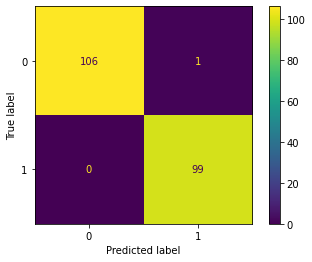

In [57]:
plot_confusion_matrix(base_xgbc, X_test, y_test)

**Great!**

**Thank you.**